<a href="https://colab.research.google.com/github/julialuszkiewicz/testy_w_domu/blob/main/praca_magisterska2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
# import libraries and data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
plt.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from xgboost import XGBRegressor


In [209]:
# import data about sale prices


sell_2023_08 = pd.read_csv('apartments_pl_2023_08.csv')
sell_2023_08 = sell_2023_08.assign(date = 'August 2023')
sell_2023_09 = pd.read_csv('apartments_pl_2023_09.csv')
sell_2023_09 = sell_2023_09.assign(date = 'September 2023')
sell_2023_10 = pd.read_csv('apartments_pl_2023_10.csv')
sell_2023_10 = sell_2023_10.assign(date = 'October 2023')
sell_2023_11 = pd.read_csv('apartments_pl_2023_11.csv')
sell_2023_11 = sell_2023_11.assign(date = 'November 2023')
sell_2023_12 = pd.read_csv('apartments_pl_2023_12.csv')
sell_2023_12 = sell_2023_12.assign(date = 'December 2023')
sell_2024_01 = pd.read_csv('apartments_pl_2024_01.csv')
sell_2024_01 = sell_2024_01.assign(date = 'January 2024')
sell_2024_02 = pd.read_csv('apartments_pl_2024_02.csv')
sell_2024_02 = sell_2024_02.assign(date = 'February 2024')
sell_2024_03 = pd.read_csv('apartments_pl_2024_03.csv')
sell_2024_03 = sell_2024_03.assign(date = 'March 2024')

In [210]:
# concatenate data into one df
df_sell = pd.concat([sell_2023_08, sell_2023_09, sell_2023_10, sell_2023_11, sell_2023_12, sell_2024_01, sell_2024_02, sell_2024_03])
df_sell = df_sell.drop_duplicates()

In [118]:
# display column names
df_sell.columns

Index(['id', 'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount',
       'buildYear', 'latitude', 'longitude', 'centreDistance', 'poiCount',
       'schoolDistance', 'clinicDistance', 'postOfficeDistance',
       'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
       'pharmacyDistance', 'ownership', 'buildingMaterial', 'condition',
       'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
       'hasStorageRoom', 'price', 'date'],
      dtype='object')

In [211]:
# shape
df_sell.shape

(134577, 29)

In [212]:
# display info
df_sell.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134577 entries, 0 to 17317
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    134577 non-null  object 
 1   city                  134577 non-null  object 
 2   type                  104834 non-null  object 
 3   squareMeters          134577 non-null  float64
 4   rooms                 134577 non-null  float64
 5   floor                 110315 non-null  float64
 6   floorCount            132816 non-null  float64
 7   buildYear             112014 non-null  float64
 8   latitude              134577 non-null  float64
 9   longitude             134577 non-null  float64
 10  centreDistance        134577 non-null  float64
 11  poiCount              134577 non-null  float64
 12  schoolDistance        134438 non-null  float64
 13  clinicDistance        134029 non-null  float64
 14  postOfficeDistance    134388 non-null  float64
 15  kinder

In [213]:
# duplikaty
print (' Zduplikowane wartosci wynoszą: {} '.format(df_sell.duplicated().sum()))

 Zduplikowane wartosci wynoszą: 0 


In [214]:
# procent wartości brakujących
missing_percent = (df_sell.isnull().sum() / len(df_sell) * 100).round(2)
missing_percent = missing_percent.apply(lambda x: f"{x}%")
missing_percent


,0
id,0.0%
city,0.0%
type,22.1%
squareMeters,0.0%
rooms,0.0%
floor,18.03%
floorCount,1.31%
buildYear,16.77%
latitude,0.0%
longitude,0.0%


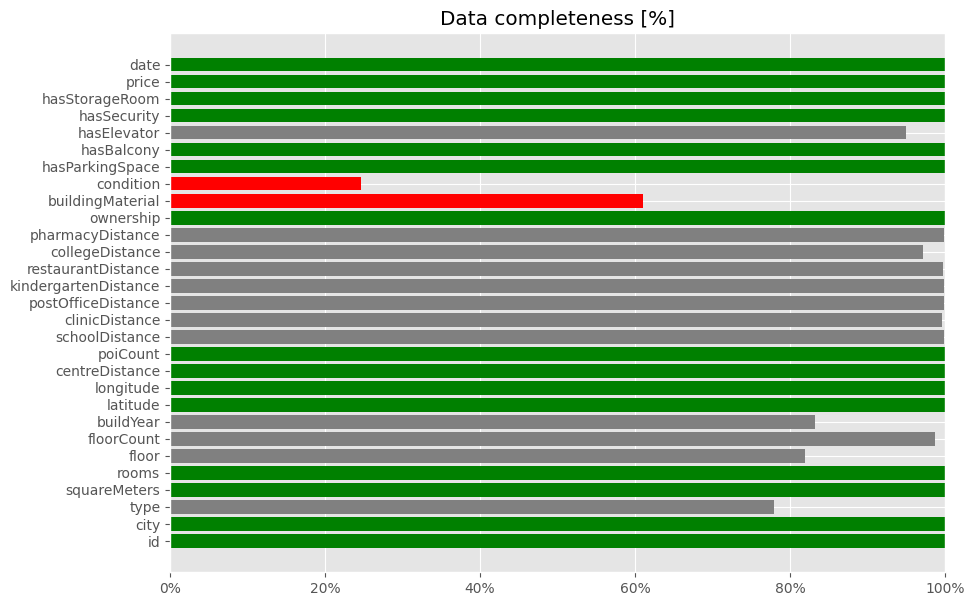

In [215]:
# wizualizacja danych niekompletnych
allCols = df_sell.columns
nonEmpty = []
barColors = []
for colName in allCols:
  completeness = 1-len(df_sell[df_sell[colName].isnull()])/len(df_sell)
  nonEmpty.append(completeness)
  if(completeness == 1):
     barColors.append('green')
  elif completeness < 0.75:
    barColors.append('red')
  else:
     barColors.append('grey')

def percent_formatter(x, pos):
    return str(round(x*100)) + "%"

fig, axs = plt.subplots(figsize=(10, 7))
axs.set_title("Data completeness [%]")
axs.barh(allCols, nonEmpty, color=barColors)
axs.set_xlim(0, 1)
axs.xaxis.set_major_formatter(percent_formatter)
plt.show()

In [216]:
# rozkład zmiennych statystycznych

np.set_printoptions(suppress=True)  # Wyłącza notację naukową
pd.options.display.float_format = '{:.2f}'.format  # Format liczbowy z 2 miejscami po przecinku

df_sell.describe()


,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,price
count,134577.00,134577.00,110315.00,132816.00,112014.00,134577.00,134577.00,134577.00,134577.00,134438.00,134029.00,134388.00,134420.00,134211.00,130752.00,134371.00,134577.00
mean,59.29,2.70,3.31,5.25,1985.49,52.04,19.46,4.32,20.72,0.41,0.97,0.52,0.37,0.35,1.44,0.36,765976.72
std,21.66,0.92,2.51,3.28,34.20,1.35,1.79,2.85,24.46,0.47,0.89,0.51,0.46,0.47,1.10,0.47,397422.84
min,25.00,1.00,1.00,1.00,1850.00,49.98,14.45,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,150000.00
25%,44.54,2.00,2.00,3.00,1966.00,51.11,18.52,1.97,7.00,0.17,0.35,0.24,0.16,0.11,0.58,0.14,500000.00
50%,55.20,3.00,3.00,4.00,1994.00,52.20,19.90,3.93,14.00,0.29,0.68,0.39,0.26,0.23,1.12,0.24,685000.00
75%,69.50,3.00,4.00,6.00,2015.00,52.44,20.99,6.12,24.00,0.47,1.24,0.62,0.42,0.41,2.05,0.41,903000.00
max,150.00,6.00,29.00,29.00,2024.00,54.61,23.21,16.94,212.00,4.95,5.00,4.97,4.96,4.99,5.00,4.99,3250000.00


Skewness: 1.740297
Kurtosis: 4.655778


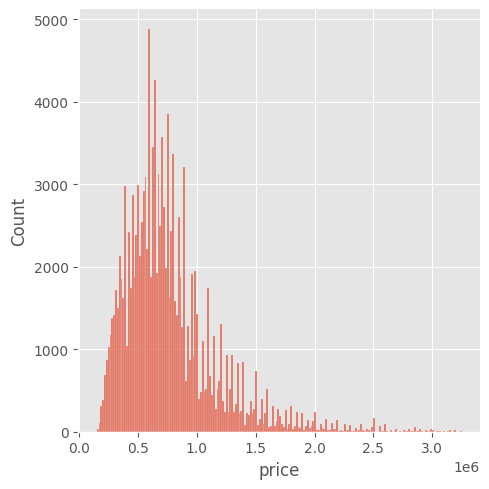

In [217]:
#skewness and kurtosis - skośność i kurtoza
sns.displot(df_sell['price']);
print("Skewness: %f" % df_sell['price'].skew())
print("Kurtosis: %f" % df_sell['price'].kurt())

z chata:

Interpretacja skośności i kurtozy na podstawie uzyskanych wartości:

Skośność (Skewness):
Wartość 1.740297 oznacza, że rozkład ceny (price) jest dodatnio skośny (skewness > 0).
Interpretacja: Ogon rozkładu jest wydłużony w prawo (w stronę wyższych wartości).

Oznacza to, że większość danych koncentruje się po lewej stronie (przy niższych cenach), ale występują pojedyncze bardzo wysokie ceny, które przesuwają średnią w górę.

Przykład: W przypadku cen nieruchomości większość mieszkań może mieć "średnie" ceny, ale kilka bardzo drogich nieruchomości (np. luksusowych) zawyża rozkład.

Kurtoza (Kurtosis):
Wartość 4.655778 wskazuje, że rozkład ma leptokurtyczny charakter (kurtosis > 3).
Interpretacja: Rozkład jest bardziej spiczasty niż normalny (rozkład Gaussa) oraz ma bardziej grubsze ogony.
To oznacza, że:
Większość wartości jest skoncentrowana wokół średniej.
Jest większe prawdopodobieństwo wystąpienia wartości odstających (bardzo wysokie lub bardzo niskie ceny).

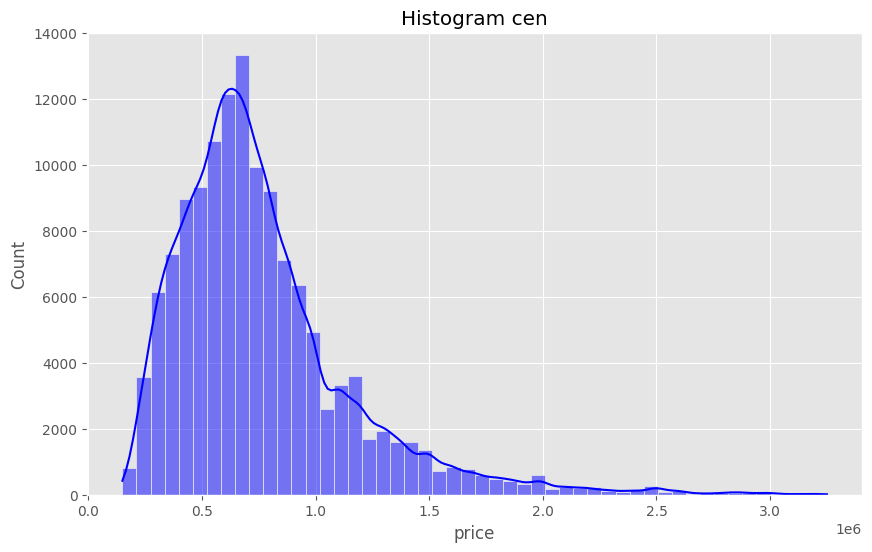

In [218]:
#wizualizacja outlierów dla kolumny 'price'
plt.figure(figsize=(10, 6))
sns.histplot(df_sell['price'], bins=50, kde=True, color='blue')
plt.title("Histogram cen")
plt.show()


<Axes: >

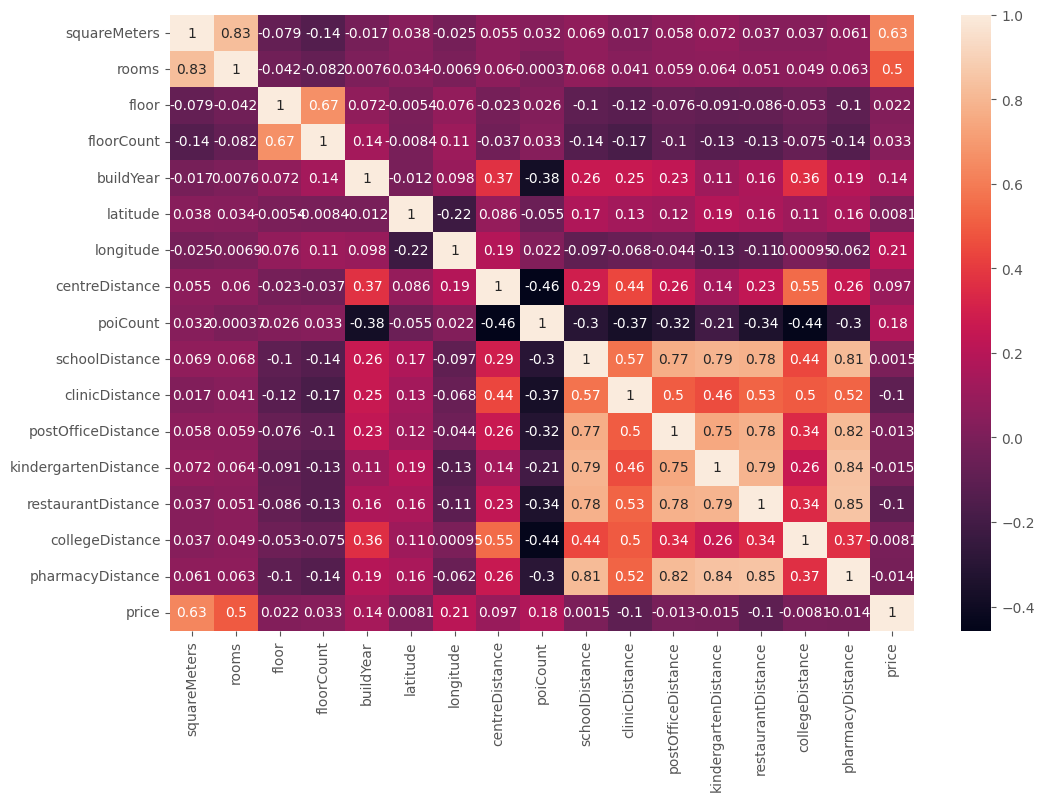

In [219]:
# heatmap - correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df_sell.corr(numeric_only = True), annot=True)

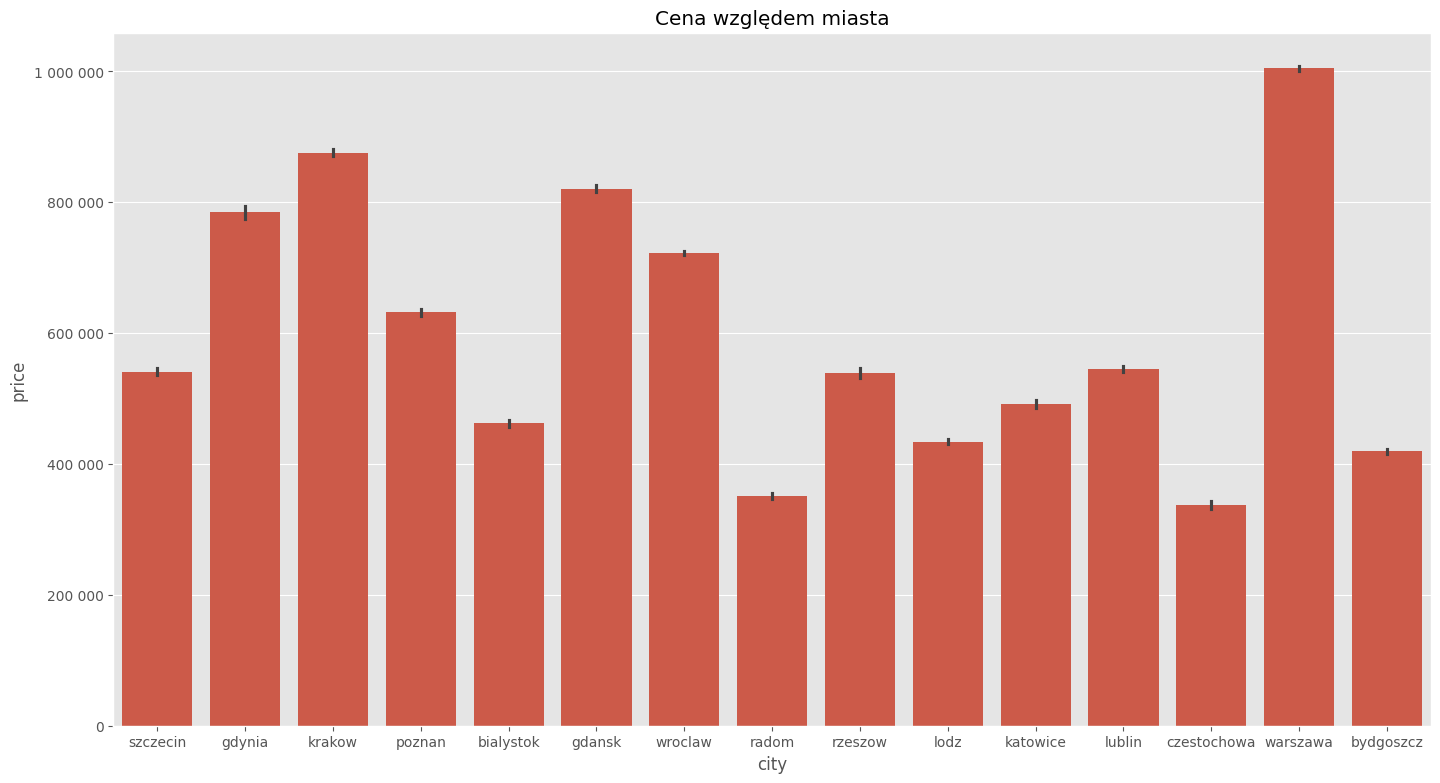

In [220]:
#wysokość ceny a miasto - wykres słupkowy
import matplotlib.ticker as mtick

plt.figure(figsize=(17, 9))
sns.barplot(x='city', y='price', data=df_sell)

# Formatowanie osi Y na numeryczny format
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(',', ' ')))
plt.title('Cena względem miasta')

plt.show()



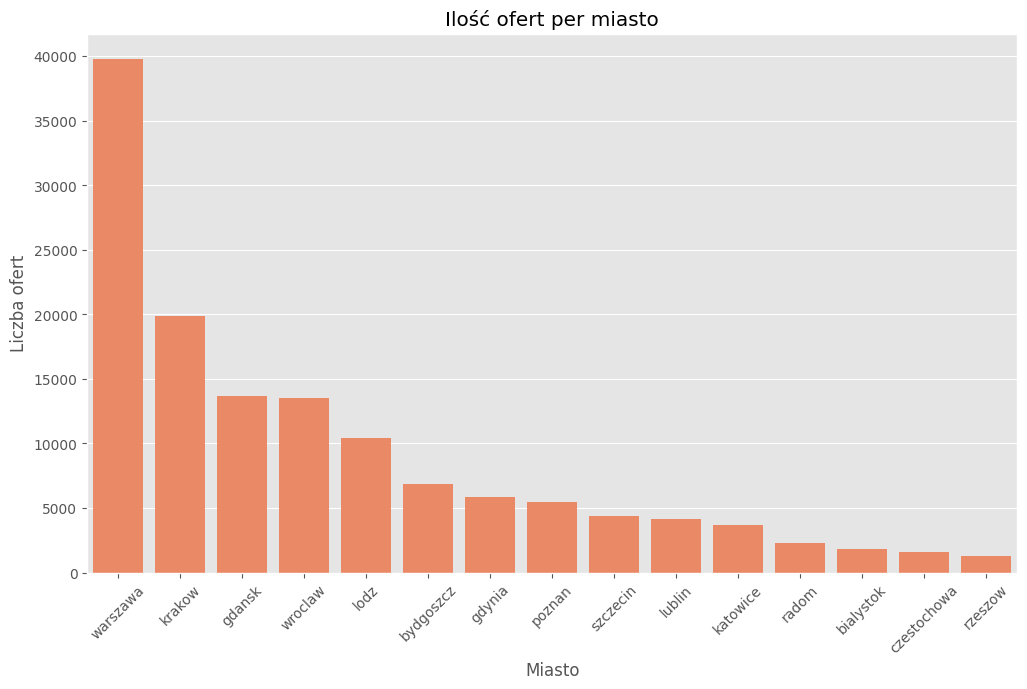

In [221]:
#ilość ofert per miasto
city_counts = df_sell['city'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=city_counts.index, y=city_counts.values, color='coral')

# Dodanie tytułów i etykiet
plt.title('Ilość ofert per miasto')
plt.xlabel('Miasto')
plt.ylabel('Liczba ofert')

# Rotacja etykiet miast (dla lepszej czytelności)
plt.xticks(rotation=45)

# Wyświetlenie wykresu
plt.show()


# **Przekształcenia zbioru danych**

In [222]:
# usuwam outliery dla kolumny 'price'
# Q1 (25 percentyl) i Q3 (75 percentyl)
Q1 = df_sell['price'].quantile(0.25)
Q3 = df_sell['price'].quantile(0.75)

# IQR
IQR = Q3 - Q1

# Wyznacz granice dla wartości odstających
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Usuń outliery
df_sell = df_sell[(df_sell['price'] >= lower_bound) & (df_sell['price'] <= upper_bound)]
df_sell.shape


(127669, 29)

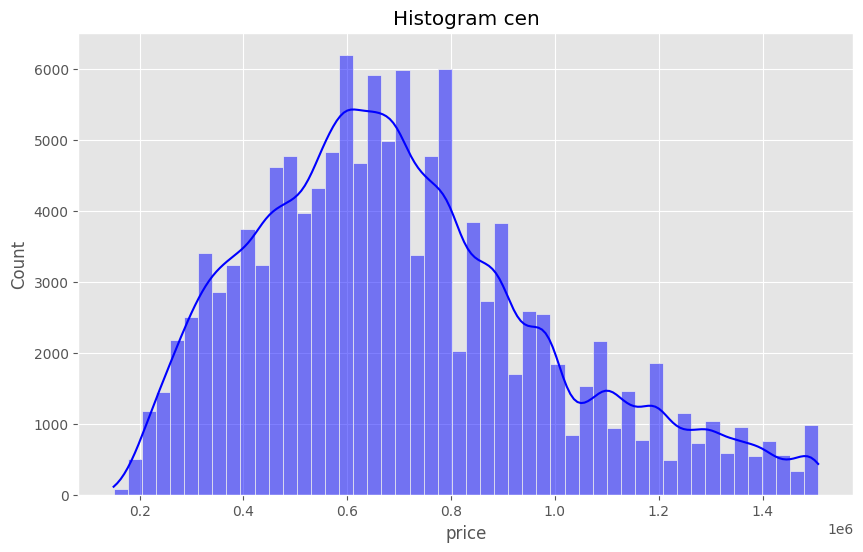

In [223]:
#histogram cen po usunięciu outlierów
plt.figure(figsize=(10, 6))
sns.histplot(df_sell['price'], bins=50, kde=True, color='blue')
plt.title("Histogram cen")
plt.show()

In [224]:
#dodaję kolumnę 'price per square meters'
# Calculate price in PLN per square meter
df_sell['price (PLN per sq.m.)'] = df_sell['price'] / df_sell['squareMeters']


In [225]:
df_sell.columns

Index(['id', 'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount',
       'buildYear', 'latitude', 'longitude', 'centreDistance', 'poiCount',
       'schoolDistance', 'clinicDistance', 'postOfficeDistance',
       'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
       'pharmacyDistance', 'ownership', 'buildingMaterial', 'condition',
       'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
       'hasStorageRoom', 'price', 'date', 'price (PLN per sq.m.)'],
      dtype='object')

In [226]:
# usuwam niepotrzebne kolumny


df_sell.drop(columns=['buildingMaterial', 'schoolDistance', 'clinicDistance',
                      'kindergartenDistance', 'restaurantDistance', 'collegeDistance',
                      'pharmacyDistance', 'postOfficeDistance', 'ownership', 'condition', 'ownership'],
             inplace=True)



In [227]:
df_sell.columns

Index(['id', 'city', 'type', 'squareMeters', 'rooms', 'floor', 'floorCount',
       'buildYear', 'latitude', 'longitude', 'centreDistance', 'poiCount',
       'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
       'hasStorageRoom', 'price', 'date', 'price (PLN per sq.m.)'],
      dtype='object')

In [228]:
# converting date, if there are mistakes - delete them
df_sell['date'] = pd.to_datetime(df_sell['date'], format='%B %Y', errors='coerce')


In [229]:
# yes/no -> binary
columns_to_be_changed = ['hasParkingSpace', 'hasBalcony', 'hasSecurity','hasStorageRoom','hasElevator']
maping = {'yes': 1, 'no': 0}

df_sell[columns_to_be_changed] = df_sell[columns_to_be_changed].apply(lambda x: x.map(maping))

# **Braki danych**

In [230]:
# procent wartości brakujących
missing_percent = (df_sell.isnull().sum() / len(df_sell) * 100).round(2)
missing_percent = missing_percent.apply(lambda x: f"{x}%")
missing_percent

,0
id,0.0%
city,0.0%
type,22.14%
squareMeters,0.0%
rooms,0.0%
floor,18.26%
floorCount,1.32%
buildYear,17.13%
latitude,0.0%
longitude,0.0%


In [231]:
#dla kolumny floorCount usuwam wiersze z NA - stanowią one bardzo mały odsetek
df_sell = df_sell.dropna(subset=['floorCount'])

In [232]:
# w kolumnie hasElevator zamieniam brakujące wartości na 0.0 - zakładam, że brak odpowiedzi oznacza, że nie ma windy
df_sell['hasElevator'] = df_sell['hasElevator'].fillna(0)
# następnie zmieniam typ danych z float na int
df_sell['hasElevator'] = df_sell['hasElevator'].astype(int)

In [233]:
df_sell['type'].value_counts()

,count
type,
blockOfFlats,60055
apartmentBuilding,19493
tenement,19104


In [234]:
df_sell['buildYear'].value_counts()

,count
buildYear,
2023.00,5966
2022.00,5542
1980.00,4632
1970.00,4297
1960.00,2968
...,...
1851.00,2
1855.00,2
1864.00,1


In [235]:
# imputacja w kolumnie 'type'
# zakładam, że kamienice były wybudowane pomiędzy 1856 a 1975
# Uzupełnianie 'type' jako 'tenement' tylko jeśli 'type' jest NaN oraz 'buildYear' spełnia warunek
df_sell.loc[(df_sell['buildYear'] >= 1856) &
            (df_sell['buildYear'] <= 1975) &
            (df_sell['type'].isna()), 'type'] = 'tenement'




In [236]:
# i w drugą stronę
df_sell.loc[(df_sell['type'] == 'tenement') & (df_sell['buildYear'].isna()), 'buildYear'] = np.random.randint(1856, 1976)


<ipython-input-237-c519d686d767>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='type', y='price', data=df_sell_reset, estimator='mean', errorbar=None, palette='coolwarm')


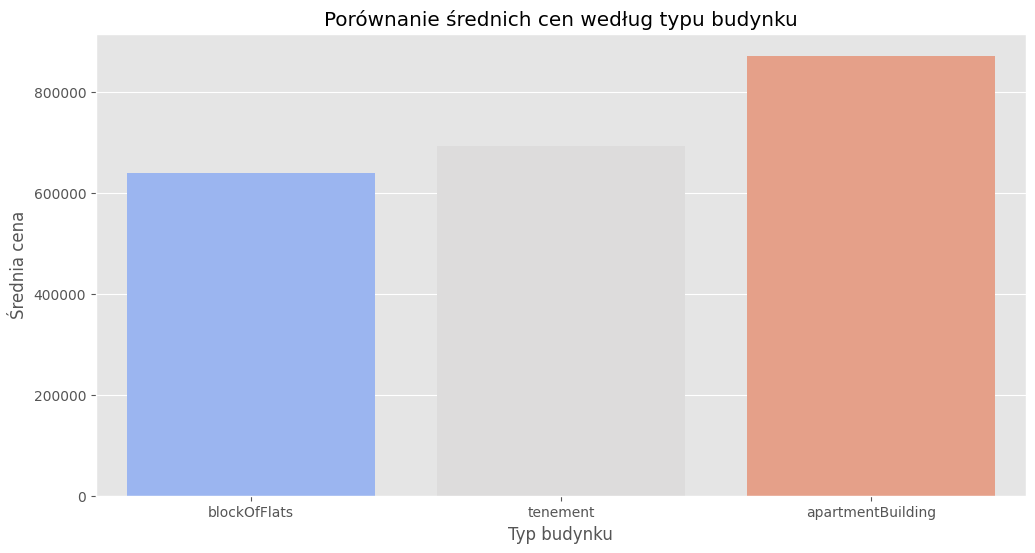

In [237]:
# wykres porównujący ceny dla typu 'apartment' a 'blockofflats'
# Resetowanie indeksu, aby uniknąć problemów z duplikatami
df_sell_reset = df_sell.reset_index(drop=True)

# Tworzenie wykresu porównującego średnie ceny dla każdego typu budynku
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='price', data=df_sell_reset, estimator='mean', errorbar=None, palette='coolwarm')

# Tytuł wykresu
plt.title('Porównanie średnich cen według typu budynku')
plt.xlabel('Typ budynku')
plt.ylabel('Średnia cena')

# Wyświetlanie wykresu
plt.show()

In [238]:
# Grupowanie po typie budynku i obliczanie statystyk opisowych dla ceny
price_stats_by_type = df_sell.groupby('type')['price'].describe()

# Wyświetlanie tabelki ze statystykami
print(price_stats_by_type)


                     count      mean       std       min       25%       50%  \
type                                                                           
apartmentBuilding 19493.00 871901.94 285088.50 210924.00 650000.00 839000.00   
blockOfFlats      60055.00 639916.29 250326.64 154040.00 450000.00 619000.00   
tenement          25303.00 693204.72 304684.35 150000.00 468645.00 650000.00   

                         75%        max  
type                                     
apartmentBuilding 1089000.00 1504035.00  
blockOfFlats       780000.00 1500000.00  
tenement           877800.00 1507200.00  


In [239]:
# Funkcja imputująca typ na podstawie ceny
def imput_type_by_price(row):
    if pd.isna(row['type']):
        # Przypisujemy typ na podstawie ceny
        if row['price'] < 450000:
            return 'blockOfFlats'
        elif 450000 <= row['price'] < 650000:
            return 'tenement'
        else:
            return 'apartmentBuilding'
    return row['type']

# Zastosowanie imputacji na brakujących wartościach w kolumnie 'type'
df_sell['type'] = df_sell.apply(imput_type_by_price, axis=1)


In [240]:
# zakładam, że apartamenty zaczęto budować po roku 2000
import random

# Funkcja imputująca randomową wartość w kolumnie 'buildYear' jeśli 'type' to 'apartmentBuilding'
def imput_buildyear(row):
    if pd.isna(row['buildYear']) and row['type'] == 'apartmentBuilding':
        return random.randint(2000, 2023)  # Losowanie wartości z zakresu 2000-2023
    return row['buildYear']

# Zastosowanie imputacji na brakujących wartościach w kolumnie 'buildYear'
df_sell['buildYear'] = df_sell.apply(imput_buildyear, axis=1)



In [241]:
# piętro uzupełniam średnią
df_sell['floor'] = df_sell['floor'].fillna(df_sell['floor'].mean())

In [242]:
# pozostałe wartości NaN w 'buildYear' usuwam
df_sell = df_sell.dropna(subset=['buildYear'])

In [243]:
missing_percent = (df_sell.isnull().sum() / len(df_sell) * 100).round(2)
missing_percent = missing_percent.apply(lambda x: f"{x}%")
missing_percent

,0
id,0.0%
city,0.0%
type,0.0%
squareMeters,0.0%
rooms,0.0%
floor,0.0%
floorCount,0.0%
buildYear,0.0%
latitude,0.0%
longitude,0.0%


In [244]:
df_sell.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113624 entries, 0 to 17316
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     113624 non-null  object        
 1   city                   113624 non-null  object        
 2   type                   113624 non-null  object        
 3   squareMeters           113624 non-null  float64       
 4   rooms                  113624 non-null  float64       
 5   floor                  113624 non-null  float64       
 6   floorCount             113624 non-null  float64       
 7   buildYear              113624 non-null  float64       
 8   latitude               113624 non-null  float64       
 9   longitude              113624 non-null  float64       
 10  centreDistance         113624 non-null  float64       
 11  poiCount               113624 non-null  float64       
 12  hasParkingSpace        113624 non-null  int64     

# **Zamiana wartości kategorycznych na numeryczne**

Wartości kategoryczne znajdują się w kolumnach city i type

In [245]:
df_sell['city'].value_counts()

,count
city,
warszawa,33321
krakow,17149
wroclaw,12528
gdansk,12140
lodz,8013
bydgoszcz,5248
gdynia,5188
poznan,4280
szczecin,3905


In [246]:
# one hot encoding dla city
df_sell = pd.get_dummies(df_sell, columns=['city'], drop_first=False)

# Sprawdzenie wyników
print(df_sell.head())

                                 id          type  squareMeters  rooms  floor  \
0  f8524536d4b09a0c8ccc0197ec9d7bde  blockOfFlats         63.00   3.00   4.00   
2  8373aa373dbc3fe7ca3b7434166b8766      tenement         73.02   3.00   2.00   
3  0a68cd14c44ec5140143ece75d739535      tenement         87.60   3.00   2.00   
5  2e190fcd6934978ca36d86ba41e842fc  blockOfFlats         63.30   3.00   2.00   
6  ec27024bfcd012728617a35dad2cb6b8  blockOfFlats         47.45   2.00   2.00   

   floorCount  buildYear  latitude  longitude  centreDistance  ...  \
0       10.00    1980.00     53.38      14.63            6.53  ...   
2        3.00    1955.00     53.45      14.55            3.24  ...   
3        3.00    1955.00     53.44      14.53            2.27  ...   
5        4.00    1997.00     53.46      14.57            4.48  ...   
6       10.00    1974.00     53.45      14.56            2.99  ...   

   city_katowice  city_krakow  city_lodz  city_lublin  city_poznan  \
0          False      

In [247]:
# one hot dla type
df_sell = pd.get_dummies(df_sell, columns=['type'], drop_first=False)

# Sprawdzenie wyników
print(df_sell.head())



                                 id  squareMeters  rooms  floor  floorCount  \
0  f8524536d4b09a0c8ccc0197ec9d7bde         63.00   3.00   4.00       10.00   
2  8373aa373dbc3fe7ca3b7434166b8766         73.02   3.00   2.00        3.00   
3  0a68cd14c44ec5140143ece75d739535         87.60   3.00   2.00        3.00   
5  2e190fcd6934978ca36d86ba41e842fc         63.30   3.00   2.00        4.00   
6  ec27024bfcd012728617a35dad2cb6b8         47.45   2.00   2.00       10.00   

   buildYear  latitude  longitude  centreDistance  poiCount  ...  city_lublin  \
0    1980.00     53.38      14.63            6.53      9.00  ...        False   
2    1955.00     53.45      14.55            3.24      9.00  ...        False   
3    1955.00     53.44      14.53            2.27     32.00  ...        False   
5    1997.00     53.46      14.57            4.48     10.00  ...        False   
6    1974.00     53.45      14.56            2.99     18.00  ...        False   

   city_poznan  city_radom  city_rzesz

In [248]:
df_sell.columns

Index(['id', 'squareMeters', 'rooms', 'floor', 'floorCount', 'buildYear',
       'latitude', 'longitude', 'centreDistance', 'poiCount',
       'hasParkingSpace', 'hasBalcony', 'hasElevator', 'hasSecurity',
       'hasStorageRoom', 'price', 'date', 'price (PLN per sq.m.)',
       'city_bialystok', 'city_bydgoszcz', 'city_czestochowa', 'city_gdansk',
       'city_gdynia', 'city_katowice', 'city_krakow', 'city_lodz',
       'city_lublin', 'city_poznan', 'city_radom', 'city_rzeszow',
       'city_szczecin', 'city_warszawa', 'city_wroclaw',
       'type_apartmentBuilding', 'type_blockOfFlats', 'type_tenement'],
      dtype='object')

In [249]:
# yes/no -> binary
columns_to_be_changed = ['city_bialystok', 'city_bydgoszcz', 'city_czestochowa', 'city_gdansk',
       'city_gdynia', 'city_katowice', 'city_krakow', 'city_lodz',
       'city_lublin', 'city_poznan', 'city_radom', 'city_rzeszow',
       'city_szczecin', 'city_warszawa', 'city_wroclaw',
       'type_apartmentBuilding', 'type_blockOfFlats', 'type_tenement']
maping = {'yes': 1, 'no': 0}

df_sell[columns_to_be_changed] = df_sell[columns_to_be_changed].apply(lambda x: x.map(maping))

# **XGBOOST**

In [194]:
!pip install streamlit
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00


In [250]:
#set up fot xgboost
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from adtk.detector import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [251]:
# Wybór cech (X) i etykiety (y)
X = df_sell.drop(['price', 'id', 'date', 'price (PLN per sq.m.)'], axis=1)  # Usuwamy kolumny, które nie są potrzebne
y = df_sell['price']

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sprawdzenie rozmiarów danych
print(f"Rozmiar X_train: {X_train.shape}, Rozmiar X_test: {X_test.shape}")
print(f"Rozmiar y_train: {y_train.shape}, Rozmiar y_test: {y_test.shape}")

Rozmiar X_train: (90899, 32), Rozmiar X_test: (22725, 32)
Rozmiar y_train: (90899,), Rozmiar y_test: (22725,)


In [252]:
# Inicjalizacja modelu XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,       # Liczba drzew
    learning_rate=0.1,      # Szybkość uczenia
    max_depth=6,            # Maksymalna głębokość drzew
    random_state=42
)

# Trenowanie modelu
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [254]:
# Predykcja na zbiorze testowym
y_pred = xgb_model.predict(X_test)

# Obliczanie metryk
mse = mean_squared_error(y_test, y_pred) # średnia kwadratów błędów
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


MSE: 10899966173.89
RMSE: 104402.90


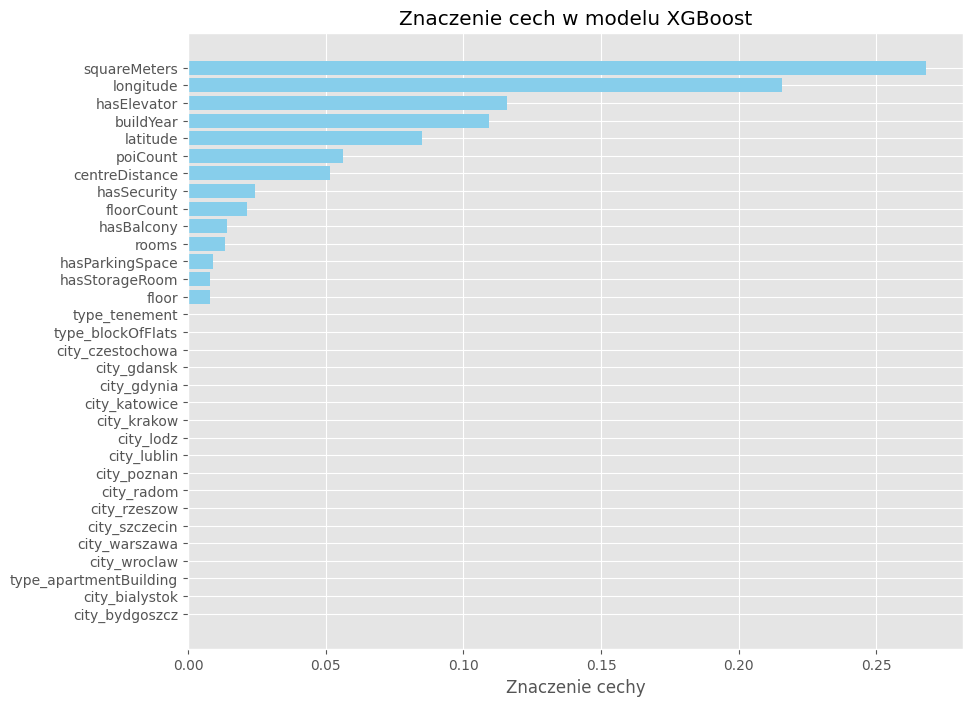

In [255]:
import matplotlib.pyplot as plt

# Znaczenie cech
xgb_feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(xgb_feature_importance)

plt.figure(figsize=(10, 8))
plt.barh(X.columns[sorted_idx], xgb_feature_importance[sorted_idx], color='skyblue')
plt.xlabel("Znaczenie cechy")
plt.title("Znaczenie cech w modelu XGBoost")
plt.show()